In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /content/drive/MyDrive/mk/gan/result_generated_f

In [ ]:
!nvidia-smi

Thu Sep  1 06:52:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://s3.amazonaws.com/pytorch-tutorial-assets/img_align_celeba.zip -P data
!unzip -qq data/img_align_celeba.zip -d data/
!ls -l data/img_align_celeba | wc -l

--2022-09-01 06:52:39--  https://s3.amazonaws.com/pytorch-tutorial-assets/img_align_celeba.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.33.216
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.33.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘data/img_align_celeba.zip’

img_align_celeba.zi 100%[===================>]   1.34G  98.1MB/s    in 14s     

2022-09-01 06:52:54 (95.8 MB/s) - ‘data/img_align_celeba.zip’ saved [1443490838/1443490838]

202600


In [ ]:
import numpy as np
import pandas as pd
import os

PIC_DIR = "/content/data/img_align_celeba/"
    
from tqdm import tqdm
from PIL import Image

IMAGES_COUNT = 10000

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
    images.append(np.uint8(pic))


100%|██████████| 10000/10000 [00:16<00:00, 610.40it/s]


In [ ]:
len(images)

10000

In [ ]:

images = np.array(images) / 255
print(images.shape)


from matplotlib import pyplot as plt


(10000, 128, 128, 3)


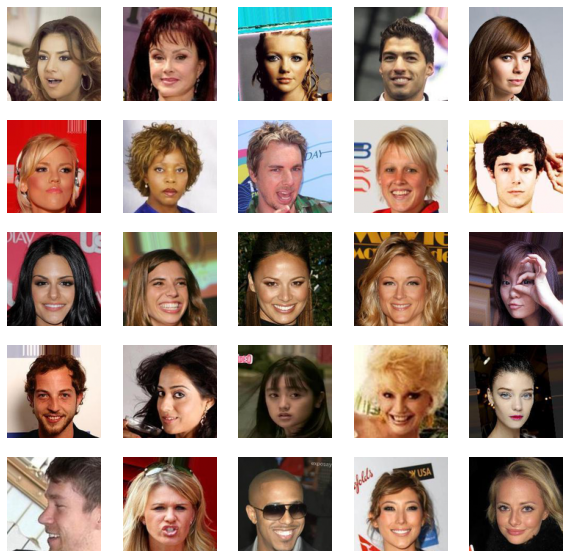

In [ ]:

plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [ ]:

from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

LATENT_DIM = 32
CHANNELS = 3


In [ ]:

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator



generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:

gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')



In [ ]:
"""
As the generator improves with training, the discriminator performance gets worse because the discriminator can’t easily tell the difference between real and fake. 
If the generator succeeds perfectly, then the discriminator has a 50% accuracy. In effect, the discriminator flips a coin to make its prediction.

GANs have a huge number of applications in cases such as Generating examples for Image Datasets, Generating Realistic Photographs, Image-to-Image Translation, Text-to-Image Translation
, Semantic-Image-to-Photo Translation, Face Frontal View Generation, Generate New Human Poses, Face Aging, Video Prediction, 3D Object Generation, etc.

During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart. 
The process reaches equilibrium when the discriminator can no longer distinguish real images from fakes.
"""

50/15000: d_loss: 0.5205,  a_loss: 0.7645.  (1.4 sec)
1111111111111111111
22222222222222
100/15000: d_loss: 0.6105,  a_loss: 0.7728.  (3.3 sec)
1111111111111111111
22222222222222
150/15000: d_loss: 0.6440,  a_loss: 0.7812.  (2.7 sec)
1111111111111111111
22222222222222
200/15000: d_loss: 0.6131,  a_loss: 0.8842.  (2.8 sec)
1111111111111111111
22222222222222
250/15000: d_loss: 0.6971,  a_loss: 1.6013.  (2.8 sec)
1111111111111111111
22222222222222
300/15000: d_loss: 0.5952,  a_loss: 1.0407.  (2.8 sec)
1111111111111111111
22222222222222
350/15000: d_loss: 0.6336,  a_loss: 0.9130.  (2.6 sec)
1111111111111111111
22222222222222
400/15000: d_loss: 0.6520,  a_loss: 1.2070.  (2.7 sec)
1111111111111111111
22222222222222
450/15000: d_loss: 0.6980,  a_loss: 0.8975.  (2.7 sec)
1111111111111111111
22222222222222
500/15000: d_loss: 0.7064,  a_loss: 0.8789.  (2.8 sec)
1111111111111111111
22222222222222
550/15000: d_loss: 0.6936,  a_loss: 0.8298.  (2.7 sec)
1111111111111111111
22222222222222
600/15000: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


1100/15000: d_loss: 0.7183,  a_loss: 0.9448.  (2.6 sec)
1111111111111111111
22222222222222
1150/15000: d_loss: 0.6580,  a_loss: 0.9197.  (2.9 sec)
1111111111111111111
22222222222222
1200/15000: d_loss: 0.9122,  a_loss: 1.4352.  (2.8 sec)
1111111111111111111
22222222222222
1250/15000: d_loss: 0.6446,  a_loss: 0.6609.  (2.8 sec)
1111111111111111111
22222222222222
1300/15000: d_loss: 0.6999,  a_loss: 0.7953.  (2.8 sec)
1111111111111111111
22222222222222
1350/15000: d_loss: 0.7094,  a_loss: 0.7395.  (2.9 sec)
1111111111111111111
22222222222222
1400/15000: d_loss: 0.6526,  a_loss: 0.8594.  (2.9 sec)
1111111111111111111
22222222222222
1450/15000: d_loss: 0.6764,  a_loss: 0.7728.  (2.9 sec)
1111111111111111111
22222222222222
1500/15000: d_loss: 0.6830,  a_loss: 0.8448.  (2.9 sec)
1111111111111111111
22222222222222
1550/15000: d_loss: 0.7017,  a_loss: 0.7705.  (2.7 sec)
1111111111111111111
22222222222222
1600/15000: d_loss: 0.7083,  a_loss: 0.7866.  (2.7 sec)
1111111111111111111
22222222222222

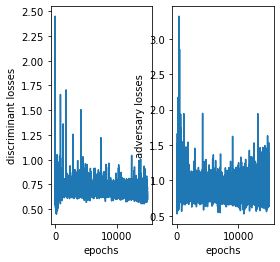

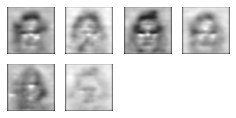

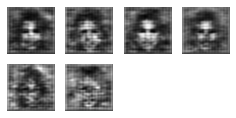

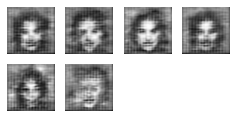

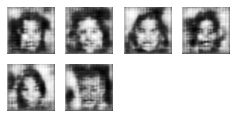

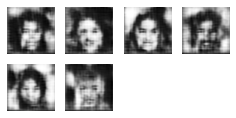

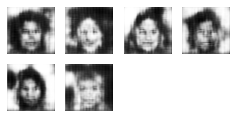

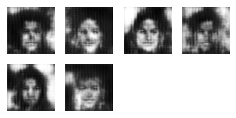

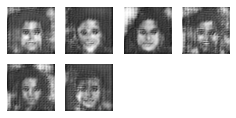

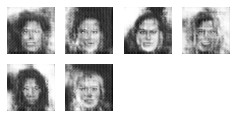

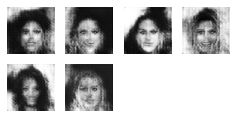

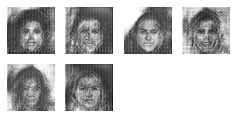

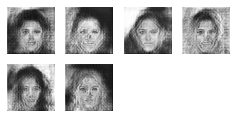

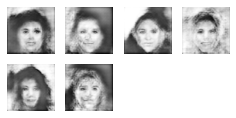

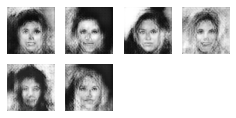

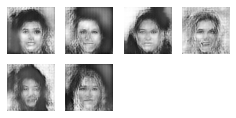

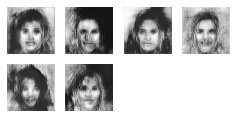

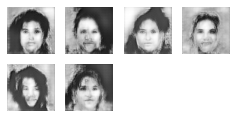

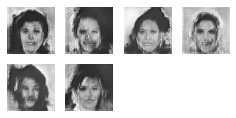

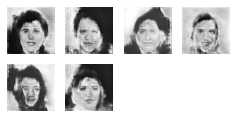

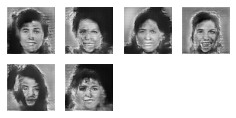

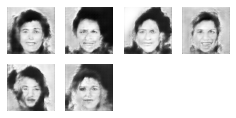

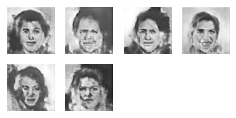

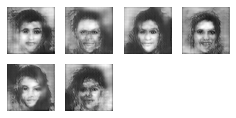

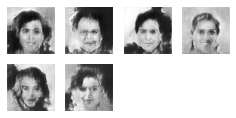

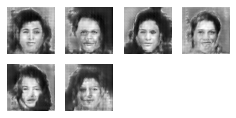

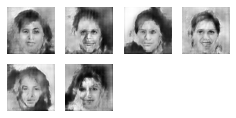

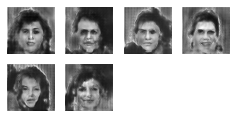

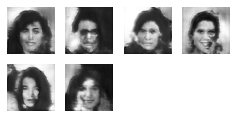

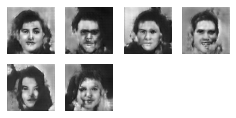

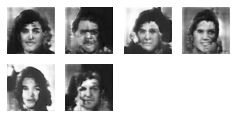

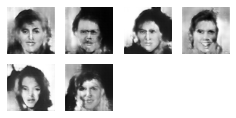

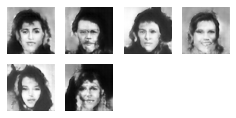

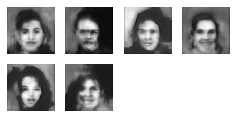

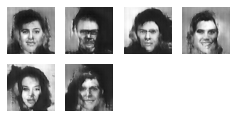

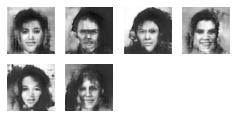

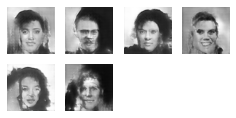

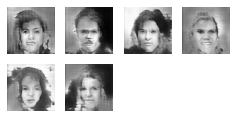

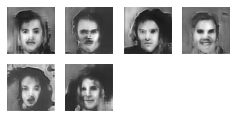

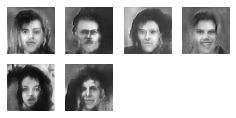

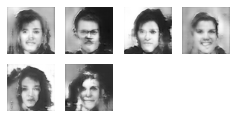

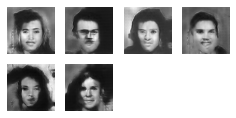

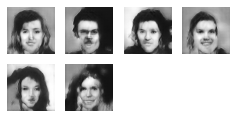

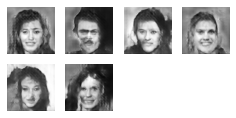

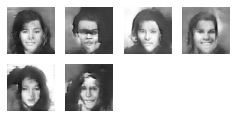

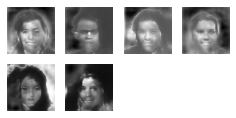

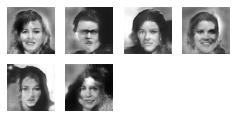

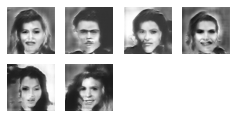

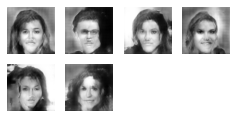

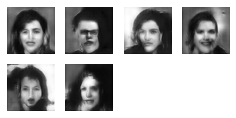

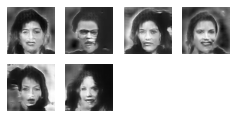

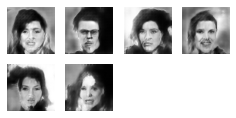

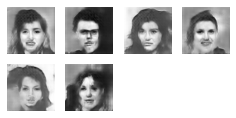

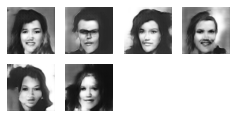

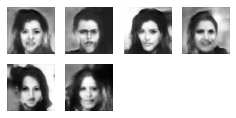

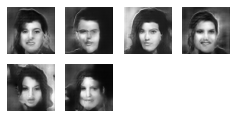

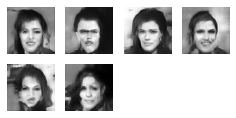

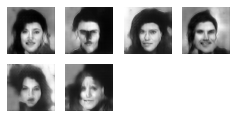

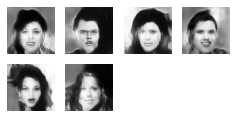

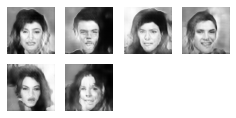

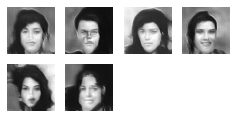

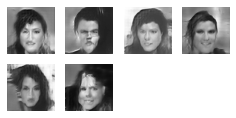

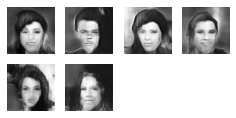

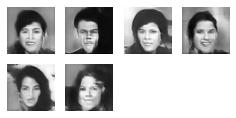

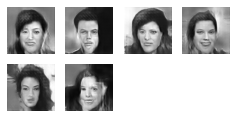

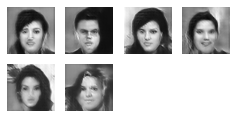

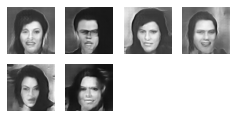

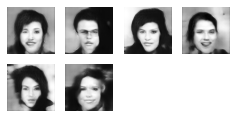

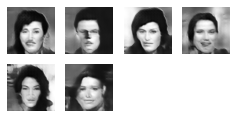

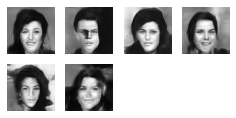

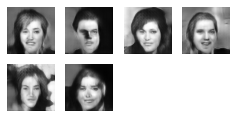

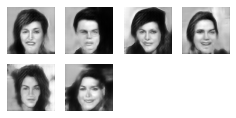

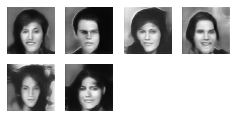

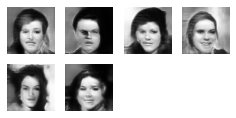

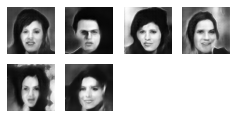

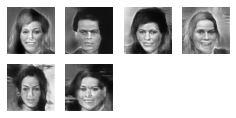

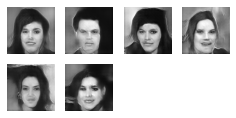

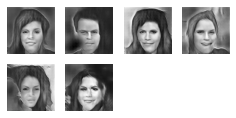

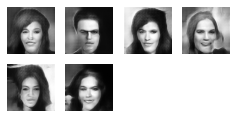

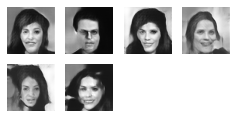

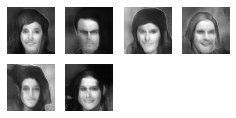

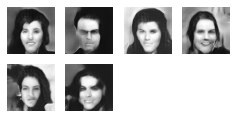

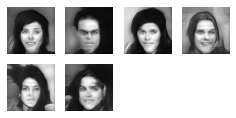

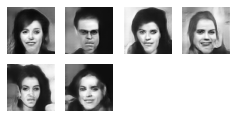

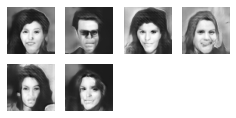

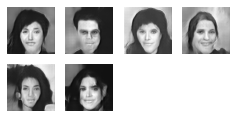

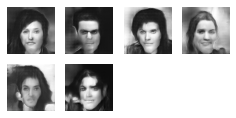

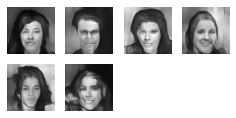

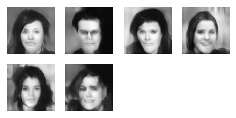

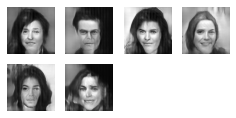

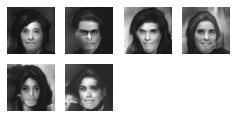

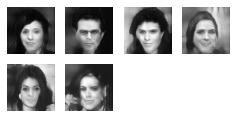

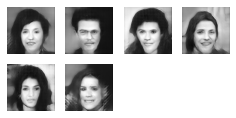

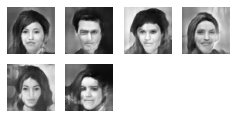

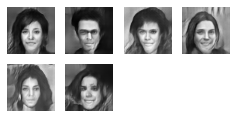

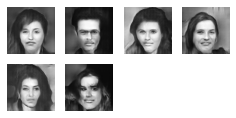

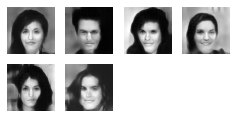

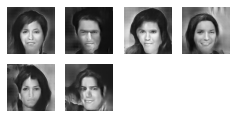

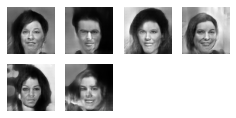

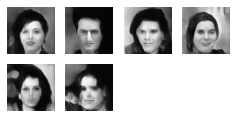

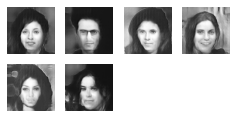

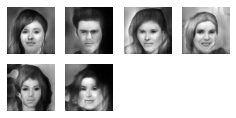

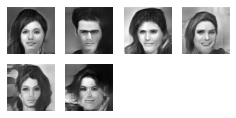

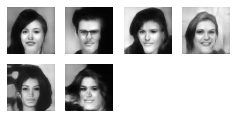

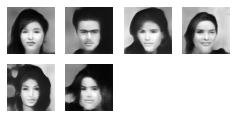

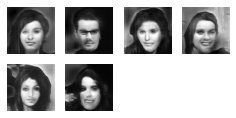

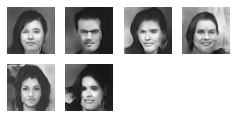

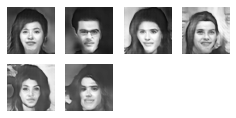

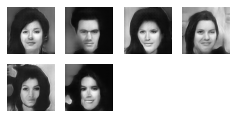

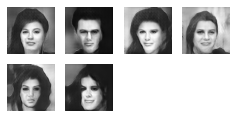

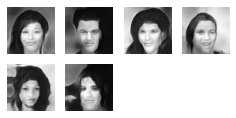

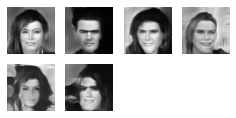

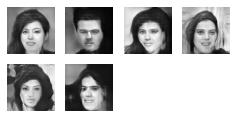

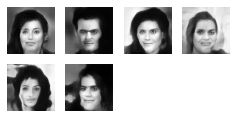

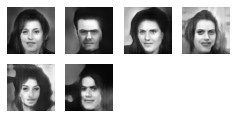

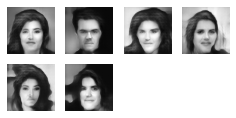

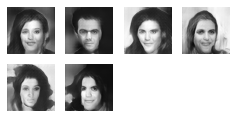

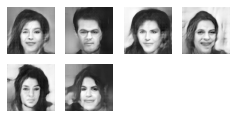

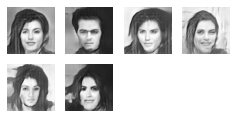

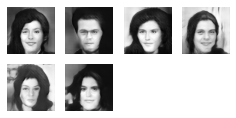

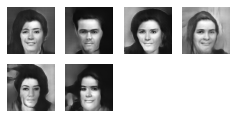

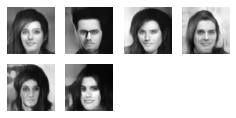

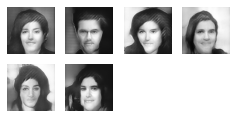

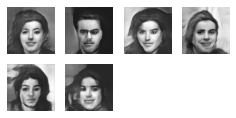

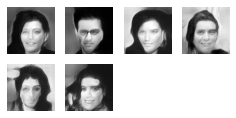

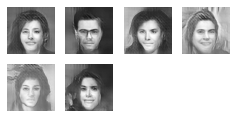

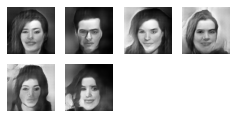

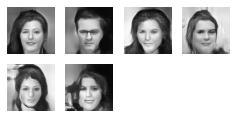

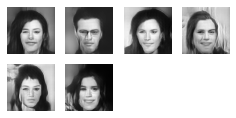

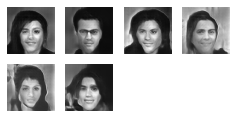

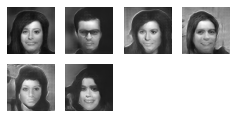

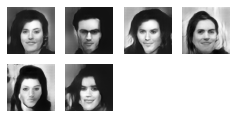

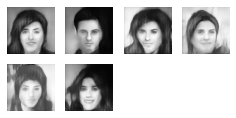

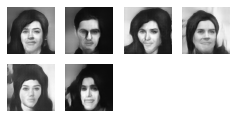

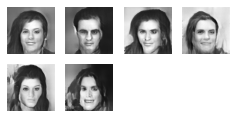

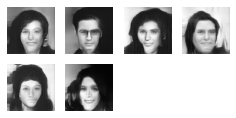

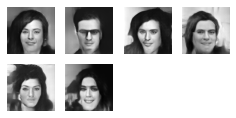

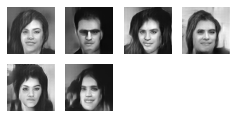

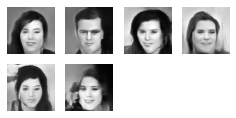

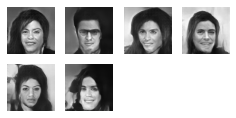

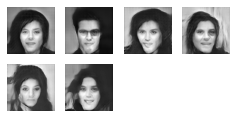

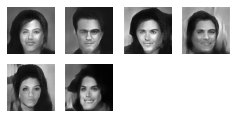

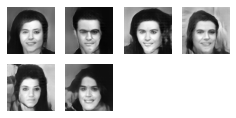

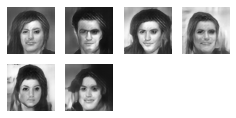

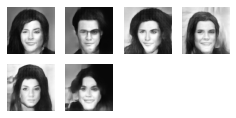

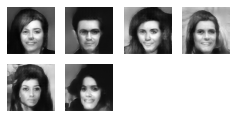

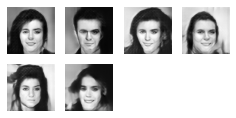

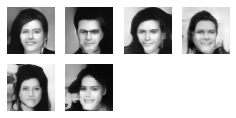

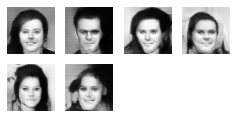

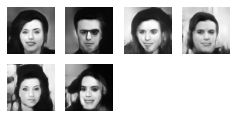

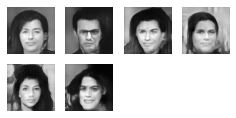

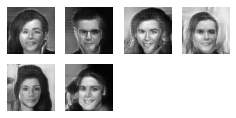

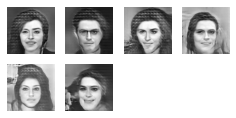

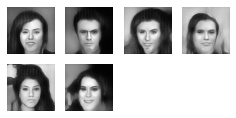

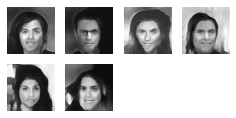

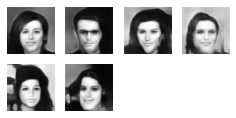

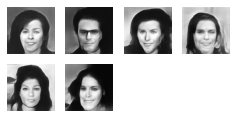

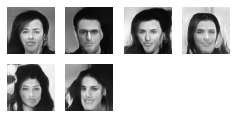

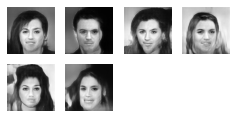

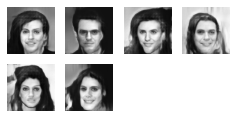

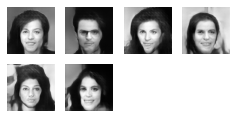

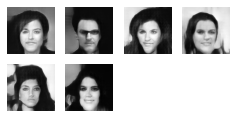

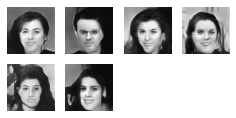

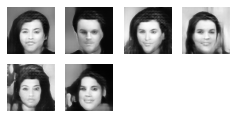

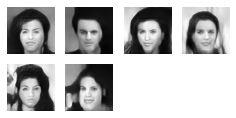

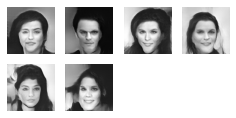

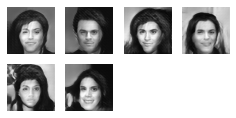

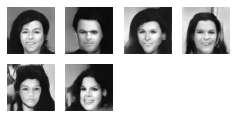

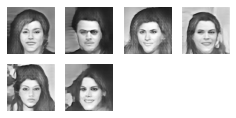

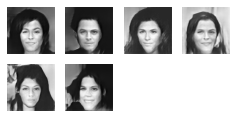

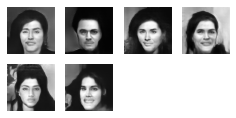

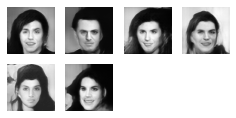

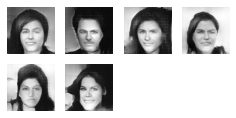

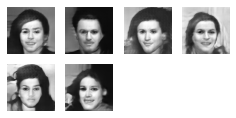

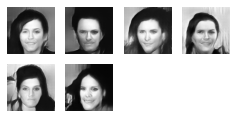

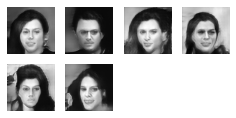

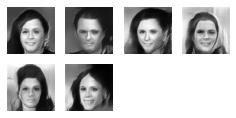

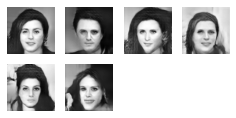

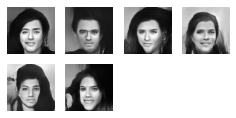

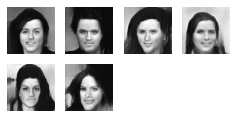

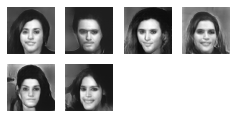

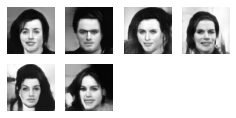

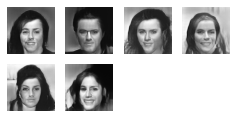

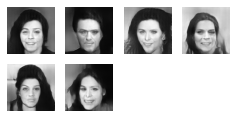

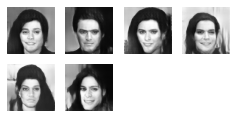

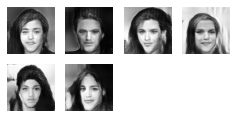

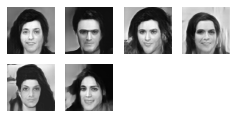

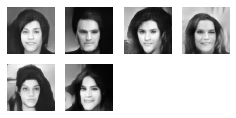

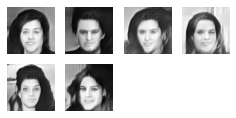

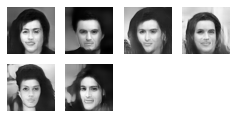

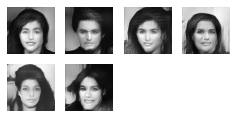

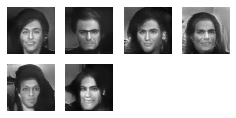

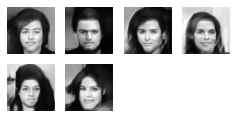

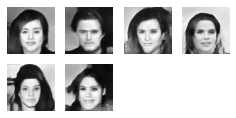

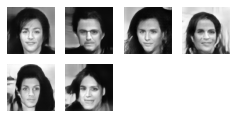

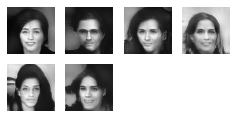

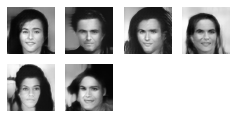

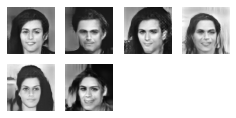

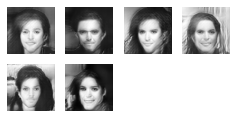

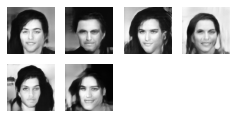

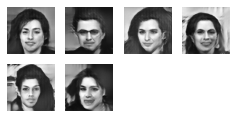

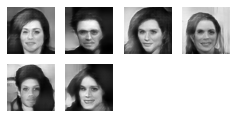

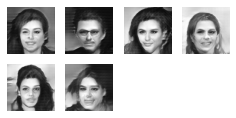

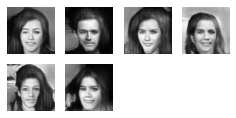

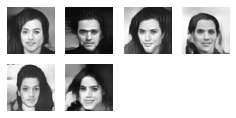

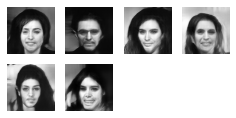

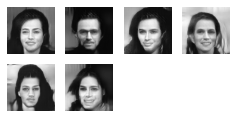

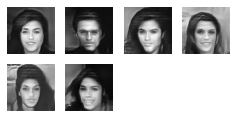

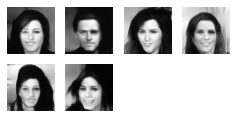

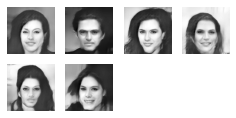

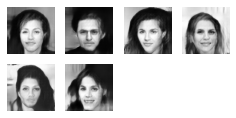

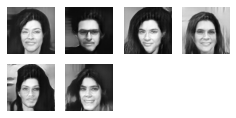

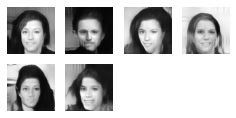

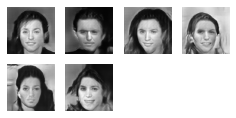

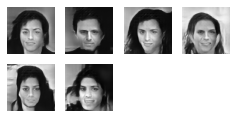

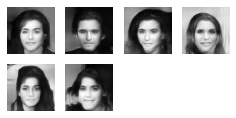

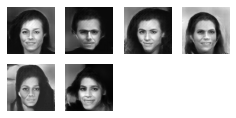

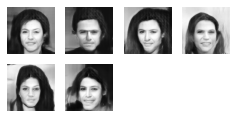

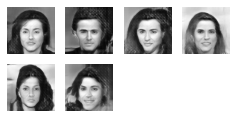

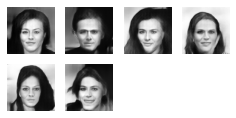

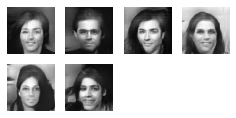

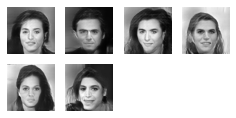

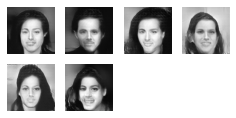

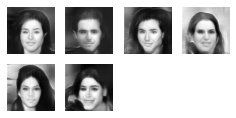

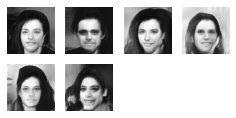

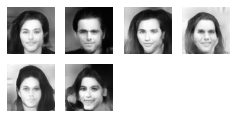

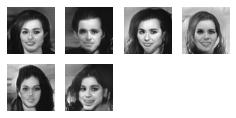

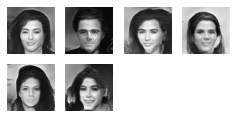

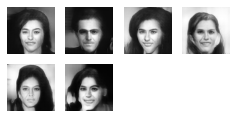

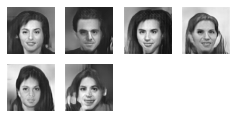

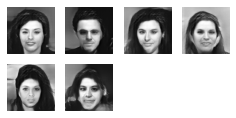

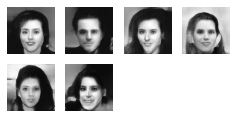

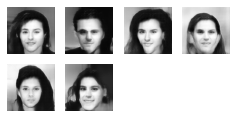

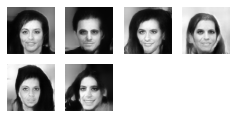

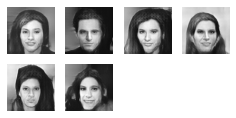

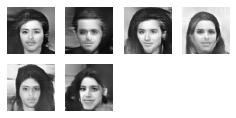

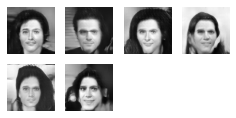

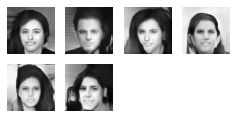

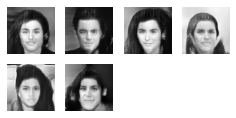

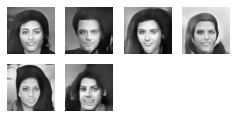

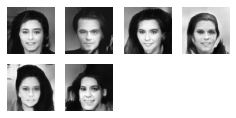

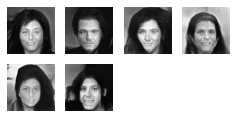

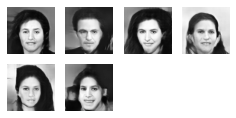

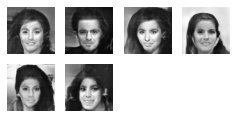

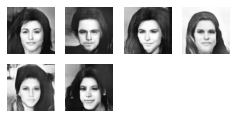

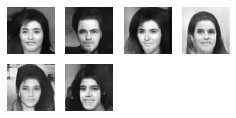

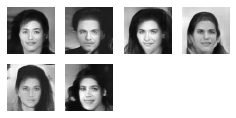

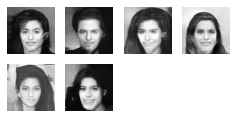

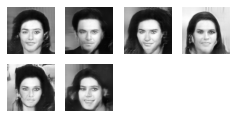

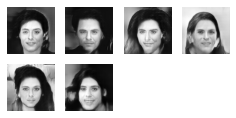

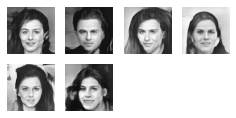

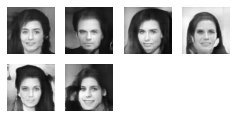

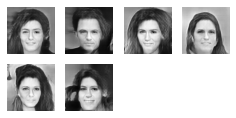

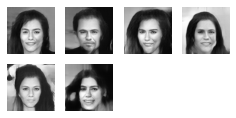

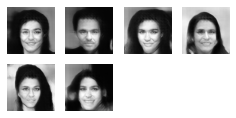

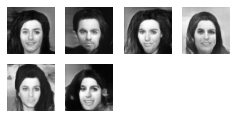

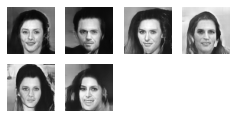

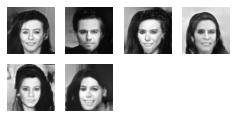

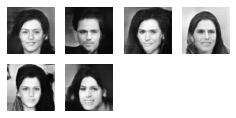

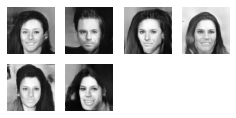

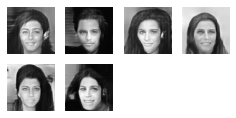

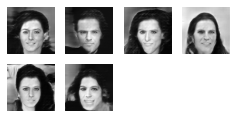

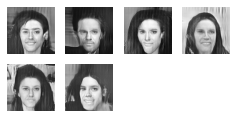

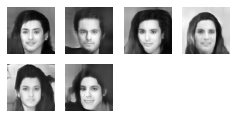

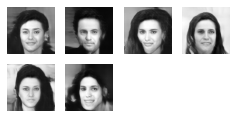

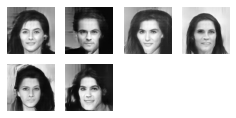

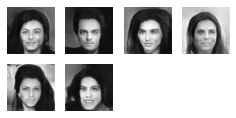

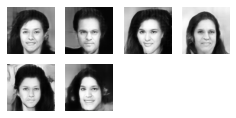

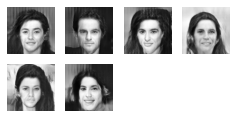

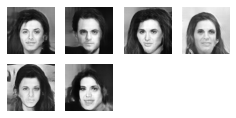

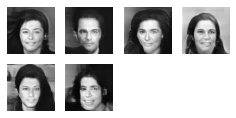

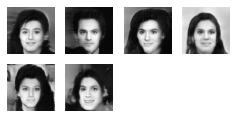

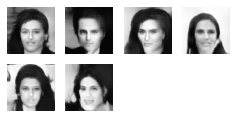

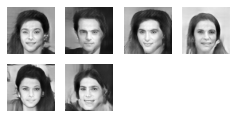

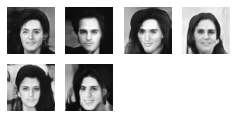

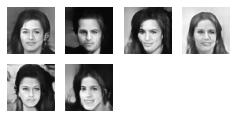

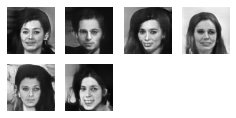

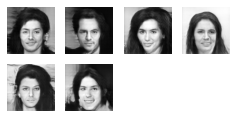

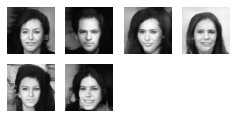

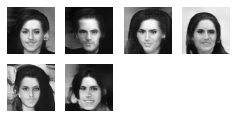

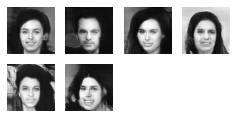

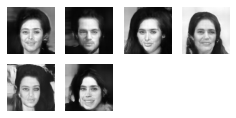

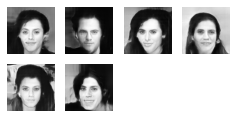

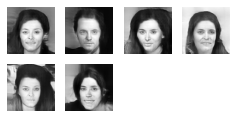

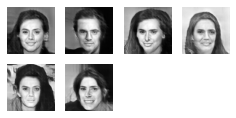

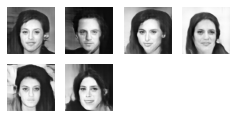

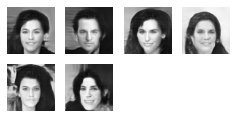

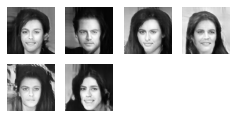

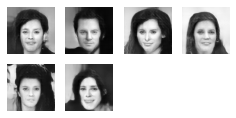

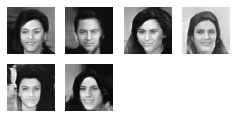

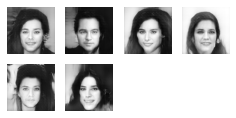

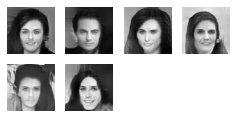

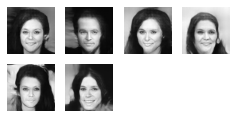

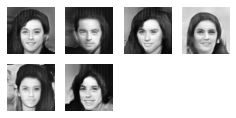

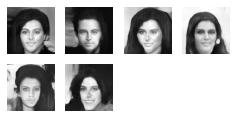

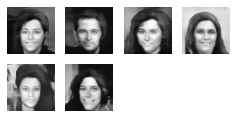

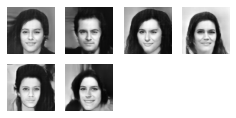

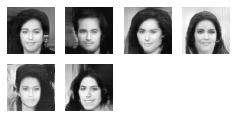

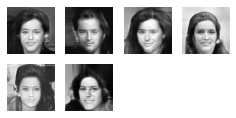

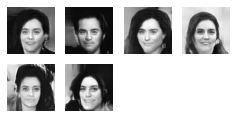

In [ ]:

import time
iters = 15000
batch_size = 16

RES_DIR = '/content/drive/MyDrive/mk/gan/result_generated'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2
control_vectors_ = np.random.normal(size=(CONTROL_SIZE_SQRT, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights('/content/drive/MyDrive/mk/gan/model/gan_.h5')
        generator.save_weights('/content/drive/MyDrive/mk/gan/model/generator_.h5')
        discriminator.save_weights('/content/drive/MyDrive/mk/gan/model/discriminator_.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        control_generated_ = generator.predict(control_vectors_)
        print("1111111111111111111")
        fig = plt.figure(figsize=(4, 4))
        #save single image at each 50 epochs
        for i in range(control_generated_.shape[0]):
            plt.subplot(4, 4, i+1)
            #plt.imshow(control_generated_[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.imsave('/content/drive/MyDrive/mk/gan/result_generated_f/image_at_epoch_{:04d}-{}.png'.format(step, i), control_generated_[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')
        print("22222222222222")
        #save 36 image in each 50 epochs
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1


plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

import imageio
import shutil

images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('/content/drive/MyDrive/mk/gan/visual.gif', images_to_gif)
#shutil.rmtree(RES_DIR)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#test-----------------------------and loading model weights----------------------------------------

In [ ]:
import numpy as np
import pandas as pd
import os    
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

LATENT_DIM = 32
CHANNELS = 3

In [ ]:

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator


In [ ]:
#load model weights
import os

images_saved = 0
LATENT_DIM = 32
CHANNELS = 3
CONTROL_SIZE_SQRT = 6
WIDTH = 128
HEIGHT = 128

g_file_name = '/content/drive/MyDrive/mk/gan/model/generator_.h5'
d_file_name = '/content/drive/MyDrive/mk/gan/model/discriminator_.h5'

generator_v1=create_generator()
descriminator_v1 = create_discriminator()

generator_v1.load_weights(g_file_name)

descriminator_v1.load_weights(d_file_name)

descriminator_v1.summary()
generator_v1.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 126, 126, 256)     7168      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 126, 126, 256)     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 256)       1048832   
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 62, 62, 256)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 256)       1048832   
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 30, 30, 256)       0   

In [ ]:
#inference
import cv2

images_saved = 0
LATENT_DIM = 32
CHANNELS = 3
#number of image to generate
CONTROL_SIZE_SQRT = 50

RES_DIR_v1= 'res_v1'
RES_DIR_v2= 'res_v2'
RES_DIR_v3= 'res_v3'
FILE_PATH = '%s/generated_%d.png'
control_vectors_ = np.random.normal(size=(CONTROL_SIZE_SQRT, LATENT_DIM)) / 2
control_generated_ = generator_v1.predict(control_vectors_)
step=11098765
fig = plt.figure(figsize=(4, 4))
control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
print("11111", control_generated_.shape[0])
print("showing colored image")
#save colored image individually
for i in range(CONTROL_SIZE_SQRT):
      im = Image.fromarray(np.uint8(control_generated_[i, :, :, :] * 255))
      im.save(FILE_PATH % (RES_DIR_v1, images_saved))
      images_saved += 1
      
print("showing gray image")
#save single gray image at each 50 epochs 
for i in range(control_generated_.shape[0]):
    #plt.subplot(4, 4, i+1)
    #plt.imshow(control_generated_[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.imsave('res_v2/image_at_epoch_{:04d}-{}.png'.format(step, i), control_generated_[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    #plt.axis('off')
    



11111 50
showing colored image
showing gray image


<Figure size 288x288 with 0 Axes>

In [ ]:
#!rm -rf res_v1 res_v2

!mkdir res_v1 res_v2

In [ ]:
import cv2
im =cv2.imread("/content/res_v1/generated_20.png")
im_=cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im_)
plt.show()

In [ ]:
!zip -r 'mode.zip' '/content/drive/MyDrive/mk/gan/model'

  adding: content/drive/MyDrive/mk/gan/model/ (stored 0%)
  adding: content/drive/MyDrive/mk/gan/model/gan_.h5 (deflated 8%)
  adding: content/drive/MyDrive/mk/gan/model/generator_.h5 (deflated 8%)
  adding: content/drive/MyDrive/mk/gan/model/discriminator_.h5 (deflated 8%)
